<a href="https://colab.research.google.com/github/falken1983/pystock_recommender/blob/main/letor_lambdaMART_lightgbm_optuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LETOR with Microsoft `lightgbm` implementation of `LambdaMART`

This notebook shows how to implement `LambdaMART` with the efficient Microsoft implementation of `xgboost`, `lightgbm`. Here we use this algo first with toy data and next, we translate to the stock ranking problem with monthly rebalancing.

In [2]:
# Importing important libraries
#!pip install optuna: Google Colab
import optuna
import joblib
import numpy as np
import pandas as pd
import lightgbm as lightgbm
import optuna.integration.lightgbm as optuna_lgb

from collections import OrderedDict
from sklearn.model_selection import ParameterGrid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.3 MB/s 
     |████████████████████████████████| 81 kB 9.8 MB/s 
     |████████████████████████████████| 209 kB 59.1 MB/s 
     |████████████████████████████████| 78 kB 8.1 MB/s 
     |████████████████████████████████| 112 kB 70.8 MB/s 
     |████████████████████████████████| 147 kB 73.1 MB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=dfeeb6448b0cb53c84844e1f8f9e38d6549f31fa36372b0249c0c2309c66b433
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


## Toy Ratings

See [Medium Article](https://medium.datadriveninvestor.com/a-practical-guide-to-lambdamart-in-lightgbm-f16a57864f6):

1. **Loading the data** (missing dummy data file, can be easily regenerated with random data)
2. **Splitting the data into train and test** (Custom splitting based on `qid`)
3. **Preparing the data for `LightGBM`**
4. **Training the `LightGBM` `LambdaMART` Model**
5. **Feature Importance**

## Stock Ratings (Pairwise)

### 1. Loading the Data

**Cloud requirements**


In [7]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  PATH = "/content/drive/MyDrive/"
except: 
  PATH = ""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Optuna** Requirements:

In [33]:
SEED = 202210

In [10]:

stock_features = pd.read_csv(
    PATH + "data/config/20220831_last_enhanced_dataset_monthly.csv",
    parse_dates=["Date"]
).iloc[:,:-1]

stock_features

,Date,symbols,RRET3M,RRET6M,RRET12M,SRET3M,SRET6M,SRET12M,ISR3M,ISR6M,ISR12M,EWVOL3M
0,2007-10-31,A,-0.045831,0.010974,0.120625,-0.286889,0.048575,0.377537,-0.043293,0.218709,0.592724,0.252168
1,2007-10-31,AA,0.049675,0.139174,0.442392,0.261090,0.517240,1.162594,0.694973,0.873066,1.274447,0.347691
2,2007-10-31,AAPL,0.391677,0.891933,1.361976,1.943524,3.129527,3.379097,3.461684,3.534918,2.782748,0.371120
3,2007-10-31,ABC,0.027289,-0.055854,0.041181,0.187520,-0.271396,0.141491,0.510378,-0.021059,0.413389,0.266703
4,2007-10-31,ABT,0.073018,-0.036949,0.187770,0.665704,-0.238196,0.855951,1.383667,-0.011155,0.947518,0.191821
...,...,...,...,...,...,...,...,...,...,...,...,...
83477,2022-07-29,XRX,-0.007128,-0.137710,-0.257794,-0.031321,-0.427877,-0.566385,0.162517,-0.085528,-0.090846,0.475500
83478,2022-07-29,Y,-0.005002,0.303045,0.271664,-0.343658,14.722666,9.332482,-0.000619,1.505580,0.904912,0.188267
83479,2022-07-29,YUM,0.030349,0.032540,-0.043256,0.242966,0.184209,-0.173151,0.597081,0.375240,-0.009783,0.232148
83480,2022-07-29,ZBH,-0.112113,-0.058252,-0.295957,-0.759136,-0.278908,-1.001985,-0.129716,-0.021664,-0.075548,0.281217


In [11]:
stock_isharpe_scores = pd.read_csv(
    PATH + "data/config/20220831_lagged_isharpe_scores_monthly.csv",
    usecols=["Date","symbols","ISR12M"],
    parse_dates=["Date"]
)

In [12]:
stock_isharpe_scores

,Date,symbols,ISR12M
0,2007-09-28,A,11.0
1,2007-09-28,AA,15.0
2,2007-09-28,AAPL,19.0
3,2007-09-28,ABC,9.0
4,2007-09-28,ABT,13.0
...,...,...,...
83946,2022-07-29,XRX,5.0
83947,2022-07-29,Y,18.0
83948,2022-07-29,YUM,8.0
83949,2022-07-29,ZBH,4.0


Merge features with relevances

In [13]:
df = pd.merge(    
        stock_features,
        stock_isharpe_scores,
    on=["Date","symbols"],
    how="inner"
).rename(columns=
    {
        "ISR12M_x": "ISR12M",
        "ISR12M_y": "relevance"
    }
)
df = df.astype({"relevance": "int8"})

In [ ]:
df

,Date,symbols,RRET3M,RRET6M,RRET12M,SRET3M,SRET6M,SRET12M,ISR3M,ISR6M,ISR12M,EWVOL3M,relevance
0,2007-10-31,A,-0.045831,0.010974,0.120625,-0.286889,0.048575,0.377537,-0.043293,0.218709,0.592724,0.252168,14
1,2007-10-31,AA,0.049675,0.139174,0.442392,0.261090,0.517240,1.162594,0.694973,0.873066,1.274447,0.347691,15
2,2007-10-31,AAPL,0.391677,0.891933,1.361976,1.943524,3.129527,3.379097,3.461684,3.534918,2.782748,0.371120,19
3,2007-10-31,ABC,0.027289,-0.055854,0.041181,0.187520,-0.271396,0.141491,0.510378,-0.021059,0.413389,0.266703,10
4,2007-10-31,ABT,0.073018,-0.036949,0.187770,0.665704,-0.238196,0.855951,1.383667,-0.011155,0.947518,0.191821,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83477,2022-07-29,XRX,-0.007128,-0.137710,-0.257794,-0.031321,-0.427877,-0.566385,0.162517,-0.085528,-0.090846,0.475500,5
83478,2022-07-29,Y,-0.005002,0.303045,0.271664,-0.343658,14.722666,9.332482,-0.000619,1.505580,0.904912,0.188267,18
83479,2022-07-29,YUM,0.030349,0.032540,-0.043256,0.242966,0.184209,-0.173151,0.597081,0.375240,-0.009783,0.232148,8
83480,2022-07-29,ZBH,-0.112113,-0.058252,-0.295957,-0.759136,-0.278908,-1.001985,-0.129716,-0.021664,-0.075548,0.281217,4


In [19]:
# Dumping for Archive
df.to_csv(
    PATH + "data/config/20220831_letor_stock_monthly_relevances_minimal.csv",
    index=False
)

### 2. Splitting the data intro train and test

In [20]:
df

,Date,symbols,RRET3M,RRET6M,RRET12M,SRET3M,SRET6M,SRET12M,ISR3M,ISR6M,ISR12M,EWVOL3M,relevance
0,2007-10-31,A,-0.045831,0.010974,0.120625,-0.286889,0.048575,0.377537,-0.043293,0.218709,0.592724,0.252168,14
1,2007-10-31,AA,0.049675,0.139174,0.442392,0.261090,0.517240,1.162594,0.694973,0.873066,1.274447,0.347691,15
2,2007-10-31,AAPL,0.391677,0.891933,1.361976,1.943524,3.129527,3.379097,3.461684,3.534918,2.782748,0.371120,19
3,2007-10-31,ABC,0.027289,-0.055854,0.041181,0.187520,-0.271396,0.141491,0.510378,-0.021059,0.413389,0.266703,10
4,2007-10-31,ABT,0.073018,-0.036949,0.187770,0.665704,-0.238196,0.855951,1.383667,-0.011155,0.947518,0.191821,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83477,2022-07-29,XRX,-0.007128,-0.137710,-0.257794,-0.031321,-0.427877,-0.566385,0.162517,-0.085528,-0.090846,0.475500,5
83478,2022-07-29,Y,-0.005002,0.303045,0.271664,-0.343658,14.722666,9.332482,-0.000619,1.505580,0.904912,0.188267,18
83479,2022-07-29,YUM,0.030349,0.032540,-0.043256,0.242966,0.184209,-0.173151,0.597081,0.375240,-0.009783,0.232148,8
83480,2022-07-29,ZBH,-0.112113,-0.058252,-0.295957,-0.759136,-0.278908,-1.001985,-0.129716,-0.021664,-0.075548,0.281217,4


In [21]:
train = df[df["Date"]<"2019"]
test = df[df["Date"]>="2019"]

In [26]:
print(f"Train/Total Prcnt Split {100*train.shape[0]/df.shape[0]:.2f}%")

Train/Total Prcnt Split 75.84%


In [17]:
train.tail(5)

,Date,symbols,RRET3M,RRET6M,RRET12M,SRET3M,SRET6M,SRET12M,ISR3M,ISR6M,ISR12M,EWVOL3M,relevance
63310,2018-12-31,XRX,-0.258182,-0.158309,-0.300977,-1.272273,-0.551624,-0.741578,-0.446705,-0.092341,-0.104940,0.437453,8
63311,2018-12-31,Y,-0.044764,0.084091,0.062682,-0.384201,0.510344,0.268990,-0.036521,0.920273,0.464947,0.230673,13
63312,2018-12-31,YUM,0.015310,0.185095,0.131370,0.131485,1.124066,0.564129,0.375977,2.005676,0.727172,0.230542,17
63313,2018-12-31,ZBH,-0.209214,-0.065355,-0.140732,-1.449341,-0.320143,-0.487463,-0.256849,-0.026257,-0.038032,0.290759,5
63314,2018-12-31,ZION,-0.182678,-0.217697,-0.190665,-1.264173,-1.065267,-0.659723,-0.219707,-0.110371,-0.043985,0.278573,7


In [28]:
print(f"No of unique monthly rebalance dates in train : {train['Date'].nunique()}")
print(f"No of unique monthly rebalance dates in test : {test['Date'].nunique()}")
print(f"Fraction : {100*train['Date'].nunique()/df['Date'].nunique():.1f}%")

No of unique monthly rebalance dates in train : 135
No of unique monthly rebalance dates in test : 43
Fraction : 75.8%


In [ ]:
df.groupby("Date").agg([np.max, np.min, np.median])["relevance"]

/tmp/ipykernel_60173/2402063399.py:1: FutureWarning: ['symbols'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby("Date").agg([np.max, np.min, np.median])["relevance"]


,amax,amin,median
Date,,,
2007-10-31,19,0,9.0
2007-11-30,19,0,9.0
2007-12-31,19,0,9.0
2008-01-31,19,0,9.0
2008-02-29,19,0,9.0
...,...,...,...
2022-03-31,19,0,9.0
2022-04-29,19,0,9.0
2022-05-31,19,0,9.0


### 3. Preparing the data for `LightGBM`

Before we move on to train the `LightGBM` `LambdaMART` on our stock data, we would need to split the data into the features and the relevance label which are essentially called `(X_train ,y_train)` for training set and `(X_test, y_test)` for test set.

In addition to this, we would also need the group , both for train and test set (evaluation set). group is essentially a `numpy` array which basically associates the queries to the features during training.

We have an static 469-stock dataset with group = [469, 469, ...], that means that you have 135+43 groups, where the first 469 records are in the first rebalance date, records 470-... are in the second rebalance month, etc.

In [29]:
# Creating a numpy array which contains group
qids_train = train.groupby("Date")["Date"].count().to_numpy()
# Keeping only the features on which we would train our model 
X_train = train.drop(["Date", "relevance", "symbols"], axis = 1)
# Relevance label for train
y_train = train[['relevance']].astype(int)

# Creating a numpy array which contains eval_group
qids_test = test.groupby("Date")["Date"].count().to_numpy()
# Keeping only the features on which we would validate our model
X_test = test.drop(["Date", "relevance", "symbols"], axis = 1)
# Relevance label for test
y_test = test[['relevance']].astype(int)

In [30]:
X_train

,RRET3M,RRET6M,RRET12M,SRET3M,SRET6M,SRET12M,ISR3M,ISR6M,ISR12M,EWVOL3M
0,-0.045831,0.010974,0.120625,-0.286889,0.048575,0.377537,-0.043293,0.218709,0.592724,0.252168
1,0.049675,0.139174,0.442392,0.261090,0.517240,1.162594,0.694973,0.873066,1.274447,0.347691
2,0.391677,0.891933,1.361976,1.943524,3.129527,3.379097,3.461684,3.534918,2.782748,0.371120
3,0.027289,-0.055854,0.041181,0.187520,-0.271396,0.141491,0.510378,-0.021059,0.413389,0.266703
4,0.073018,-0.036949,0.187770,0.665704,-0.238196,0.855951,1.383667,-0.011155,0.947518,0.191821
...,...,...,...,...,...,...,...,...,...,...
63310,-0.258182,-0.158309,-0.300977,-1.272273,-0.551624,-0.741578,-0.446705,-0.092341,-0.104940,0.437453
63311,-0.044764,0.084091,0.062682,-0.384201,0.510344,0.268990,-0.036521,0.920273,0.464947,0.230673
63312,0.015310,0.185095,0.131370,0.131485,1.124066,0.564129,0.375977,2.005676,0.727172,0.230542
63313,-0.209214,-0.065355,-0.140732,-1.449341,-0.320143,-0.487463,-0.256849,-0.026257,-0.038032,0.290759


In [31]:
y_train

,relevance
0,14
1,15
2,19
3,10
4,17
...,...
63310,8
63311,13
63312,17
63313,5


In [32]:
len(qids_train), len(qids_test)

(135, 43)

### 4. Training the `LightGBM` `LambdaMART` Model


While most of the parameters are very well documented on the LightGBM’s official website, I’ll discuss a few here which aren’t.

* First thing first, the only objective which is available for Ranking in LightGBM is `lambdarank` and LambdaMART is the _boosted tree version_ of _LambdaRank_. So, In essence `lambdarank` objective along with `gbdt` boosting_type is what LambdaMART is.

Second, Ranking objectives in LightGBM use `label_gain_` to store the gain of each label value. By default, `label_gain_[i] = (1 << i) - 1`. So the default label gain only works with a _maximum label value **31**_. So, in case your label value exceeds **31** , you will have to specify your customized label_gain .

Third, in the fit method, while setting the parameters eval_set and eval_group , if you wish to evaluate your model only on test set, then you will only have to pass (X_test, y_test) and qids_test to eval_set and eval_group parameters respectively.

Non-Tuned `LGBMRanker`:

In [ ]:
# Creating the ranker object
ranker = lightgbm.LGBMRanker(
    n_estimators=15000,
    random_state=42,
    num_leaves=41,
    learning_rate=0.002,
    max_bin =20,
    subsample_for_bin=20000,
    colsample_bytree=0.7,
    n_jobs=6
)                    

In [ ]:
# Training the model
ranker.fit(
      X=X_train,
      y=y_train,
      group=qids_train,
      verbose=100,
      eval_set=[(X_train, y_train),(X_test, y_test)],
      eval_group=[qids_train, qids_test],
      eval_at=[25] # The size of ventile-based portfolios
)

**Hyperparameter Tuning** with `Optuna`:

In [36]:
# try parameter tuning
def objective(trial):
    # search param
    param = {
        'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1), 
        #'subsample': trial.suggest_uniform('subsample', 1e-8, 1), 
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100), 
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000), 
        'learning_rate': trial.suggest_loguniform('learning_rate', 2e-3, 1e-1), 
    }
     
    #train model
    #ranker = lightgbm.LGBMRanker(n_estimators=1000, **param, random_state=SEED,)
    ranker = lightgbm.LGBMRanker(**param, random_state=SEED,)
    ranker.fit(
        X_train,
        y_train,
        group=qids_train,
        eval_set=[(X_test, y_test)],
        eval_group=[qids_test],
        eval_at=[25], # calc validation ndcg@1,3,5,10,20
        early_stopping_rounds=50,
        verbose=10
    )
    
    # maximize mean ndcg
    scores = []
    for name, score in ranker.best_score_['valid_0'].items():
        scores.append(score)
    return np.mean(scores)

In [37]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=SEED) #fix random seed
                           )
study.optimize(objective, n_trials=20)

[I 2022-10-25 09:34:21,898] A new study created in memory with name: no-name-b8274684-9f7d-483d-bca7-e3e63490a80a
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/

Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.77666
[20]	valid_0's ndcg@25: 0.753866
[30]	valid_0's ndcg@25: 0.763455
[40]	valid_0's ndcg@25: 0.770433
[50]	valid_0's ndcg@25: 0.763121


[I 2022-10-25 09:34:33,182] Trial 0 finished with value: 0.7840036942293185 and parameters: {'lambda_l1': 0.00043156365335523194, 'lambda_l2': 0.00013556118082428656, 'max_depth': 7, 'num_leaves': 106, 'colsample_bytree': 0.39740262519409775, 'min_child_samples': 89, 'n_estimators': 7011, 'learning_rate': 0.0048127445197241195}. Best is trial 0 with value: 0.7840036942293185.


Early stopping, best iteration is:
[8]	valid_0's ndcg@25: 0.784004
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.776655
[20]	valid_0's ndcg@25: 0.756044
[30]	valid_0's ndcg@25: 0.769957
[40]	valid_0's ndcg@25: 0.772874
[50]	valid_0's ndcg@25: 0.771478


[I 2022-10-25 09:34:43,305] Trial 1 finished with value: 0.7809423706416707 and parameters: {'lambda_l1': 5.42713750793306e-05, 'lambda_l2': 3.2981461573114076e-07, 'max_depth': 7, 'num_leaves': 114, 'colsample_bytree': 0.3371471022847372, 'min_child_samples': 64, 'n_estimators': 2462, 'learning_rate': 0.046555425321473984}. Best is trial 0 with value: 0.7840036942293185.


Early stopping, best iteration is:
[8]	valid_0's ndcg@25: 0.780942
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.794102
[20]	valid_0's ndcg@25: 0.764724
[30]	valid_0's ndcg@25: 0.780688
[40]	valid_0's ndcg@25: 0.781798
[50]	valid_0's ndcg@25: 0.778963


[I 2022-10-25 09:34:52,754] Trial 2 finished with value: 0.8117057431898764 and parameters: {'lambda_l1': 2.893804426138419, 'lambda_l2': 0.00011916159573295241, 'max_depth': 4, 'num_leaves': 59, 'colsample_bytree': 0.3365942691813023, 'min_child_samples': 40, 'n_estimators': 5601, 'learning_rate': 0.0026354629800921}. Best is trial 2 with value: 0.8117057431898764.


Early stopping, best iteration is:
[6]	valid_0's ndcg@25: 0.811706
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.774493
[20]	valid_0's ndcg@25: 0.755059
[30]	valid_0's ndcg@25: 0.766586
[40]	valid_0's ndcg@25: 0.772707
[50]	valid_0's ndcg@25: 0.770791


[I 2022-10-25 09:35:02,724] Trial 3 finished with value: 0.7813841082871552 and parameters: {'lambda_l1': 0.10719642026777626, 'lambda_l2': 0.21311894504205917, 'max_depth': 7, 'num_leaves': 232, 'colsample_bytree': 0.3981830532714489, 'min_child_samples': 83, 'n_estimators': 6892, 'learning_rate': 0.011930150775785795}. Best is trial 2 with value: 0.8117057431898764.


Early stopping, best iteration is:
[8]	valid_0's ndcg@25: 0.781384
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.752091
[20]	valid_0's ndcg@25: 0.757705
[30]	valid_0's ndcg@25: 0.761961
[40]	valid_0's ndcg@25: 0.768931
[50]	valid_0's ndcg@25: 0.776188
[60]	valid_0's ndcg@25: 0.779311
[70]	valid_0's ndcg@25: 0.785496
[80]	valid_0's ndcg@25: 0.791265
[90]	valid_0's ndcg@25: 0.793223
[100]	valid_0's ndcg@25: 0.798549
[110]	valid_0's ndcg@25: 0.799936
[120]	valid_0's ndcg@25: 0.802455
[130]	valid_0's ndcg@25: 0.802881
[140]	valid_0's ndcg@25: 0.804295
[150]	valid_0's ndcg@25: 0.803685
[160]	valid_0's ndcg@25: 0.804689
[170]	valid_0's ndcg@25: 0.807313
[180]	valid_0's ndcg@25: 0.807355
[190]	valid_0's ndcg@25: 0.808519
[200]	valid_0's ndcg@25: 0.811009
[210]	valid_0's ndcg@25: 0.812032
[220]	valid_0's ndcg@25: 0.812734
[230]	valid_0's ndcg@25: 0.814175
[240]	valid_0's ndcg@25: 0.815919
[250]	valid_0's ndcg@25: 0.816075
[260]	valid_0's ndcg@25: 0.816

[I 2022-10-25 09:36:14,110] Trial 4 finished with value: 0.8233051271553875 and parameters: {'lambda_l1': 2.770345770020284e-07, 'lambda_l2': 0.379815634876467, 'max_depth': 4, 'num_leaves': 137, 'colsample_bytree': 0.8170811944466188, 'min_child_samples': 14, 'n_estimators': 2797, 'learning_rate': 0.06159845241987205}. Best is trial 4 with value: 0.8233051271553875.


Early stopping, best iteration is:
[347]	valid_0's ndcg@25: 0.823305
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.764247
[20]	valid_0's ndcg@25: 0.780433
[30]	valid_0's ndcg@25: 0.7822
[40]	valid_0's ndcg@25: 0.787982
[50]	valid_0's ndcg@25: 0.792694
[60]	valid_0's ndcg@25: 0.795295
[70]	valid_0's ndcg@25: 0.79879
[80]	valid_0's ndcg@25: 0.800932
[90]	valid_0's ndcg@25: 0.803788
[100]	valid_0's ndcg@25: 0.807944
[110]	valid_0's ndcg@25: 0.809467
[120]	valid_0's ndcg@25: 0.811928
[130]	valid_0's ndcg@25: 0.81212
[140]	valid_0's ndcg@25: 0.814209
[150]	valid_0's ndcg@25: 0.814827
[160]	valid_0's ndcg@25: 0.815671
[170]	valid_0's ndcg@25: 0.816609
[180]	valid_0's ndcg@25: 0.816721
[190]	valid_0's ndcg@25: 0.81736
[200]	valid_0's ndcg@25: 0.81904
[210]	valid_0's ndcg@25: 0.817268
[220]	valid_0's ndcg@25: 0.817565
[230]	valid_0's ndcg@25: 0.818842
[240]	valid_0's ndcg@25: 0.819641
[250]	valid_0's ndcg@25: 0.81983
[260]	valid_0's ndcg@25: 0.820781
[

[I 2022-10-25 09:37:46,633] Trial 5 finished with value: 0.826085910172206 and parameters: {'lambda_l1': 0.05205661174726287, 'lambda_l2': 0.0018955231739572925, 'max_depth': 3, 'num_leaves': 41, 'colsample_bytree': 0.7860310531086838, 'min_child_samples': 20, 'n_estimators': 3973, 'learning_rate': 0.0770533054807486}. Best is trial 5 with value: 0.826085910172206.


Early stopping, best iteration is:
[455]	valid_0's ndcg@25: 0.826086
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.746499
[20]	valid_0's ndcg@25: 0.744679
[30]	valid_0's ndcg@25: 0.74547
[40]	valid_0's ndcg@25: 0.746722
[50]	valid_0's ndcg@25: 0.748276


[I 2022-10-25 09:37:55,885] Trial 6 finished with value: 0.7578034830818489 and parameters: {'lambda_l1': 0.0013792788917901127, 'lambda_l2': 0.10363644106791921, 'max_depth': 7, 'num_leaves': 71, 'colsample_bytree': 0.5688383669299047, 'min_child_samples': 55, 'n_estimators': 6600, 'learning_rate': 0.007891961757534448}. Best is trial 5 with value: 0.826085910172206.


Early stopping, best iteration is:
[5]	valid_0's ndcg@25: 0.757803
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.731277
[20]	valid_0's ndcg@25: 0.722928
[30]	valid_0's ndcg@25: 0.725841
[40]	valid_0's ndcg@25: 0.729866
[50]	valid_0's ndcg@25: 0.729479


[I 2022-10-25 09:38:04,771] Trial 7 finished with value: 0.7381917284295085 and parameters: {'lambda_l1': 0.000662437922577192, 'lambda_l2': 0.3209177127015027, 'max_depth': 6, 'num_leaves': 36, 'colsample_bytree': 0.8902939814002574, 'min_child_samples': 65, 'n_estimators': 1069, 'learning_rate': 0.008953942411637338}. Best is trial 5 with value: 0.826085910172206.


Early stopping, best iteration is:
[2]	valid_0's ndcg@25: 0.738192
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.773759
[20]	valid_0's ndcg@25: 0.768121
[30]	valid_0's ndcg@25: 0.76182
[40]	valid_0's ndcg@25: 0.774305
[50]	valid_0's ndcg@25: 0.774642


[I 2022-10-25 09:38:14,083] Trial 8 finished with value: 0.7846520758308871 and parameters: {'lambda_l1': 3.108809294575709e-05, 'lambda_l2': 5.469334457669194, 'max_depth': 8, 'num_leaves': 200, 'colsample_bytree': 0.2623513527184921, 'min_child_samples': 36, 'n_estimators': 5147, 'learning_rate': 0.05596312566206822}. Best is trial 5 with value: 0.826085910172206.


Early stopping, best iteration is:
[2]	valid_0's ndcg@25: 0.784652
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.789643
[20]	valid_0's ndcg@25: 0.800053
[30]	valid_0's ndcg@25: 0.79242
[40]	valid_0's ndcg@25: 0.795607
[50]	valid_0's ndcg@25: 0.796538
[60]	valid_0's ndcg@25: 0.79596


[I 2022-10-25 09:38:25,889] Trial 9 finished with value: 0.8000528248869073 and parameters: {'lambda_l1': 3.991774157124074e-07, 'lambda_l2': 0.05068227897711181, 'max_depth': 3, 'num_leaves': 140, 'colsample_bytree': 0.4682230131130586, 'min_child_samples': 12, 'n_estimators': 7119, 'learning_rate': 0.05207810285746414}. Best is trial 5 with value: 0.826085910172206.


[70]	valid_0's ndcg@25: 0.793343
Early stopping, best iteration is:
[20]	valid_0's ndcg@25: 0.800053
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.778481
[20]	valid_0's ndcg@25: 0.783071
[30]	valid_0's ndcg@25: 0.778362
[40]	valid_0's ndcg@25: 0.779305
[50]	valid_0's ndcg@25: 0.781662
[60]	valid_0's ndcg@25: 0.777068


[I 2022-10-25 09:38:37,669] Trial 10 finished with value: 0.7859747584673877 and parameters: {'lambda_l1': 0.08519943166093073, 'lambda_l2': 4.69549472919801e-07, 'max_depth': 3, 'num_leaves': 6, 'colsample_bytree': 0.7277904374222791, 'min_child_samples': 24, 'n_estimators': 9414, 'learning_rate': 0.025706412111211573}. Best is trial 5 with value: 0.826085910172206.


Early stopping, best iteration is:
[18]	valid_0's ndcg@25: 0.785975
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.738462
[20]	valid_0's ndcg@25: 0.757154
[30]	valid_0's ndcg@25: 0.768807
[40]	valid_0's ndcg@25: 0.778783
[50]	valid_0's ndcg@25: 0.785666
[60]	valid_0's ndcg@25: 0.792735
[70]	valid_0's ndcg@25: 0.796907
[80]	valid_0's ndcg@25: 0.799154
[90]	valid_0's ndcg@25: 0.803081
[100]	valid_0's ndcg@25: 0.804377
[110]	valid_0's ndcg@25: 0.807533
[120]	valid_0's ndcg@25: 0.810014
[130]	valid_0's ndcg@25: 0.812836
[140]	valid_0's ndcg@25: 0.814527
[150]	valid_0's ndcg@25: 0.815949
[160]	valid_0's ndcg@25: 0.817138
[170]	valid_0's ndcg@25: 0.818772
[180]	valid_0's ndcg@25: 0.819484
[190]	valid_0's ndcg@25: 0.819995
[200]	valid_0's ndcg@25: 0.819053
[210]	valid_0's ndcg@25: 0.81988
[220]	valid_0's ndcg@25: 0.821015
[230]	valid_0's ndcg@25: 0.821717
[240]	valid_0's ndcg@25: 0.82302
[250]	valid_0's ndcg@25: 0.822246
[260]	valid_0's ndcg@25: 0.8217

[I 2022-10-25 09:39:28,997] Trial 11 finished with value: 0.8233000041786033 and parameters: {'lambda_l1': 2.1794401764444017e-08, 'lambda_l2': 0.002671838748948905, 'max_depth': 4, 'num_leaves': 171, 'colsample_bytree': 0.9890895910190871, 'min_child_samples': 7, 'n_estimators': 3321, 'learning_rate': 0.09825380373479257}. Best is trial 5 with value: 0.826085910172206.


[290]	valid_0's ndcg@25: 0.821357
Early stopping, best iteration is:
[241]	valid_0's ndcg@25: 0.8233
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.728134
[20]	valid_0's ndcg@25: 0.750394
[30]	valid_0's ndcg@25: 0.745166
[40]	valid_0's ndcg@25: 0.752672
[50]	valid_0's ndcg@25: 0.758136
[60]	valid_0's ndcg@25: 0.760174
[70]	valid_0's ndcg@25: 0.763908
[80]	valid_0's ndcg@25: 0.767129
[90]	valid_0's ndcg@25: 0.769781
[100]	valid_0's ndcg@25: 0.771078
[110]	valid_0's ndcg@25: 0.775953
[120]	valid_0's ndcg@25: 0.778329
[130]	valid_0's ndcg@25: 0.779253
[140]	valid_0's ndcg@25: 0.781028
[150]	valid_0's ndcg@25: 0.782839
[160]	valid_0's ndcg@25: 0.784572
[170]	valid_0's ndcg@25: 0.785096
[180]	valid_0's ndcg@25: 0.785773
[190]	valid_0's ndcg@25: 0.787719
[200]	valid_0's ndcg@25: 0.789663
[210]	valid_0's ndcg@25: 0.791629
[220]	valid_0's ndcg@25: 0.791842
[230]	valid_0's ndcg@25: 0.793364
[240]	valid_0's ndcg@25: 0.794781
[250]	valid_0's ndcg@25: 0.795

[I 2022-10-25 09:42:26,494] Trial 12 finished with value: 0.8231626638487213 and parameters: {'lambda_l1': 4.462114329975848e-07, 'lambda_l2': 0.0006766883738174727, 'max_depth': 4, 'num_leaves': 156, 'colsample_bytree': 0.7434320352622804, 'min_child_samples': 23, 'n_estimators': 3642, 'learning_rate': 0.026850235338457366}. Best is trial 5 with value: 0.826085910172206.


Early stopping, best iteration is:
[945]	valid_0's ndcg@25: 0.823163
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.758067
[20]	valid_0's ndcg@25: 0.768956
[30]	valid_0's ndcg@25: 0.77196
[40]	valid_0's ndcg@25: 0.75592
[50]	valid_0's ndcg@25: 0.746546


[I 2022-10-25 09:42:35,617] Trial 13 finished with value: 0.8006381771652664 and parameters: {'lambda_l1': 0.13732468183106034, 'lambda_l2': 1.4352557700312656e-05, 'max_depth': 5, 'num_leaves': 98, 'colsample_bytree': 0.11000807473022539, 'min_child_samples': 24, 'n_estimators': 1394, 'learning_rate': 0.09005050097480485}. Best is trial 5 with value: 0.826085910172206.


Early stopping, best iteration is:
[3]	valid_0's ndcg@25: 0.800638
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.774801
[20]	valid_0's ndcg@25: 0.777829
[30]	valid_0's ndcg@25: 0.774831
[40]	valid_0's ndcg@25: 0.773089
[50]	valid_0's ndcg@25: 0.780311
[60]	valid_0's ndcg@25: 0.778656
[70]	valid_0's ndcg@25: 0.779162
[80]	valid_0's ndcg@25: 0.777214
[90]	valid_0's ndcg@25: 0.781434
[100]	valid_0's ndcg@25: 0.781604
[110]	valid_0's ndcg@25: 0.783157
[120]	valid_0's ndcg@25: 0.783973
[130]	valid_0's ndcg@25: 0.785617
[140]	valid_0's ndcg@25: 0.785884
[150]	valid_0's ndcg@25: 0.787037
[160]	valid_0's ndcg@25: 0.789899
[170]	valid_0's ndcg@25: 0.791276
[180]	valid_0's ndcg@25: 0.791887
[190]	valid_0's ndcg@25: 0.791876
[200]	valid_0's ndcg@25: 0.792972
[210]	valid_0's ndcg@25: 0.79378
[220]	valid_0's ndcg@25: 0.795421
[230]	valid_0's ndcg@25: 0.79568
[240]	valid_0's ndcg@25: 0.796012
[250]	valid_0's ndcg@25: 0.796987
[260]	valid_0's ndcg@25: 0.79851

[I 2022-10-25 09:44:28,356] Trial 14 finished with value: 0.8189459426310586 and parameters: {'lambda_l1': 8.830142511653307, 'lambda_l2': 7.876122976623919, 'max_depth': 3, 'num_leaves': 11, 'colsample_bytree': 0.7118987982848475, 'min_child_samples': 40, 'n_estimators': 4256, 'learning_rate': 0.022068691071442912}. Best is trial 5 with value: 0.826085910172206.


Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.73228
[20]	valid_0's ndcg@25: 0.733703
[30]	valid_0's ndcg@25: 0.734496
[40]	valid_0's ndcg@25: 0.747211
[50]	valid_0's ndcg@25: 0.75384
[60]	valid_0's ndcg@25: 0.758493
[70]	valid_0's ndcg@25: 0.765208
[80]	valid_0's ndcg@25: 0.76899
[90]	valid_0's ndcg@25: 0.773475
[100]	valid_0's ndcg@25: 0.776285
[110]	valid_0's ndcg@25: 0.778949
[120]	valid_0's ndcg@25: 0.782085
[130]	valid_0's ndcg@25: 0.784286
[140]	valid_0's ndcg@25: 0.78865
[150]	valid_0's ndcg@25: 0.791874
[160]	valid_0's ndcg@25: 0.794254
[170]	valid_0's ndcg@25: 0.7974
[180]	valid_0's ndcg@25: 0.799452
[190]	valid_0's ndcg@25: 0.79992
[200]	valid_0's ndcg@25: 0.802614
[210]	valid_0's ndcg@25: 0.804251
[220]	valid_0's ndcg@25: 0.805522
[230]	valid_0's ndcg@25: 0.805342
[240]	valid_0's ndcg@25: 0.806187
[250]	valid_0's ndcg@25: 0.807592
[260]	valid_0's ndcg@25: 0.808069
[270]	valid_0's ndcg@25: 0.80914
[280]	valid_0's ndcg@25: 0.809977
[29

[I 2022-10-25 09:45:58,430] Trial 15 finished with value: 0.82017483431967 and parameters: {'lambda_l1': 2.8760411013434884e-06, 'lambda_l2': 1.0271804163705369e-08, 'max_depth': 5, 'num_leaves': 81, 'colsample_bytree': 0.8607649086284959, 'min_child_samples': 6, 'n_estimators': 2331, 'learning_rate': 0.041882922125083294}. Best is trial 5 with value: 0.826085910172206.


Early stopping, best iteration is:
[496]	valid_0's ndcg@25: 0.820175
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.745683
[20]	valid_0's ndcg@25: 0.76437
[30]	valid_0's ndcg@25: 0.770759
[40]	valid_0's ndcg@25: 0.778985
[50]	valid_0's ndcg@25: 0.782959
[60]	valid_0's ndcg@25: 0.787175
[70]	valid_0's ndcg@25: 0.790659
[80]	valid_0's ndcg@25: 0.794618
[90]	valid_0's ndcg@25: 0.797988
[100]	valid_0's ndcg@25: 0.800716
[110]	valid_0's ndcg@25: 0.80339
[120]	valid_0's ndcg@25: 0.805204
[130]	valid_0's ndcg@25: 0.806017
[140]	valid_0's ndcg@25: 0.805798
[150]	valid_0's ndcg@25: 0.806219
[160]	valid_0's ndcg@25: 0.806444
[170]	valid_0's ndcg@25: 0.807189
[180]	valid_0's ndcg@25: 0.810261
[190]	valid_0's ndcg@25: 0.810785
[200]	valid_0's ndcg@25: 0.810888
[210]	valid_0's ndcg@25: 0.813382
[220]	valid_0's ndcg@25: 0.814187
[230]	valid_0's ndcg@25: 0.815354
[240]	valid_0's ndcg@25: 0.814677
[250]	valid_0's ndcg@25: 0.814538
[260]	valid_0's ndcg@25: 0.815

[I 2022-10-25 09:47:18,998] Trial 16 finished with value: 0.8247628348847222 and parameters: {'lambda_l1': 1.0197523723109362e-08, 'lambda_l2': 0.009596602005076643, 'max_depth': 4, 'num_leaves': 183, 'colsample_bytree': 0.6049074587120886, 'min_child_samples': 18, 'n_estimators': 4613, 'learning_rate': 0.07317808712683715}. Best is trial 5 with value: 0.826085910172206.


Early stopping, best iteration is:
[429]	valid_0's ndcg@25: 0.824763
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.751584
[20]	valid_0's ndcg@25: 0.757477
[30]	valid_0's ndcg@25: 0.759488
[40]	valid_0's ndcg@25: 0.763909
[50]	valid_0's ndcg@25: 0.766004
[60]	valid_0's ndcg@25: 0.772216
[70]	valid_0's ndcg@25: 0.776614
[80]	valid_0's ndcg@25: 0.776949
[90]	valid_0's ndcg@25: 0.780945
[100]	valid_0's ndcg@25: 0.783201
[110]	valid_0's ndcg@25: 0.787427
[120]	valid_0's ndcg@25: 0.786841
[130]	valid_0's ndcg@25: 0.787527
[140]	valid_0's ndcg@25: 0.788441
[150]	valid_0's ndcg@25: 0.789593
[160]	valid_0's ndcg@25: 0.790213
[170]	valid_0's ndcg@25: 0.789771
[180]	valid_0's ndcg@25: 0.789523
[190]	valid_0's ndcg@25: 0.790242
[200]	valid_0's ndcg@25: 0.792133
[210]	valid_0's ndcg@25: 0.793226
[220]	valid_0's ndcg@25: 0.79402
[230]	valid_0's ndcg@25: 0.795205
[240]	valid_0's ndcg@25: 0.795521
[250]	valid_0's ndcg@25: 0.796726
[260]	valid_0's ndcg@25: 0.79

[I 2022-10-25 09:48:30,481] Trial 17 finished with value: 0.8074208392756622 and parameters: {'lambda_l1': 0.016234566579624108, 'lambda_l2': 0.009716547880617422, 'max_depth': 5, 'num_leaves': 248, 'colsample_bytree': 0.5625998144265251, 'min_child_samples': 33, 'n_estimators': 4796, 'learning_rate': 0.03429431952435663}. Best is trial 5 with value: 0.826085910172206.


Early stopping, best iteration is:
[387]	valid_0's ndcg@25: 0.807421
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.755956
[20]	valid_0's ndcg@25: 0.772634
[30]	valid_0's ndcg@25: 0.769881
[40]	valid_0's ndcg@25: 0.778744
[50]	valid_0's ndcg@25: 0.783664
[60]	valid_0's ndcg@25: 0.784134
[70]	valid_0's ndcg@25: 0.784971
[80]	valid_0's ndcg@25: 0.786257
[90]	valid_0's ndcg@25: 0.78768
[100]	valid_0's ndcg@25: 0.786897
[110]	valid_0's ndcg@25: 0.790164
[120]	valid_0's ndcg@25: 0.790145
[130]	valid_0's ndcg@25: 0.789991
[140]	valid_0's ndcg@25: 0.789797
[150]	valid_0's ndcg@25: 0.791712
[160]	valid_0's ndcg@25: 0.792758
[170]	valid_0's ndcg@25: 0.793831
[180]	valid_0's ndcg@25: 0.794673
[190]	valid_0's ndcg@25: 0.796015
[200]	valid_0's ndcg@25: 0.795867
[210]	valid_0's ndcg@25: 0.798026
[220]	valid_0's ndcg@25: 0.799069
[230]	valid_0's ndcg@25: 0.798903
[240]	valid_0's ndcg@25: 0.797967
[250]	valid_0's ndcg@25: 0.799024
[260]	valid_0's ndcg@25: 0.80

[I 2022-10-25 09:50:12,409] Trial 18 finished with value: 0.8140617301621839 and parameters: {'lambda_l1': 1.4388184763875983e-08, 'lambda_l2': 1.1368236351755943e-05, 'max_depth': 3, 'num_leaves': 217, 'colsample_bytree': 0.6389569493076879, 'min_child_samples': 46, 'n_estimators': 8952, 'learning_rate': 0.018932685666597}. Best is trial 5 with value: 0.826085910172206.


Early stopping, best iteration is:
[584]	valid_0's ndcg@25: 0.814062
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.722892
[20]	valid_0's ndcg@25: 0.740691
[30]	valid_0's ndcg@25: 0.754613
[40]	valid_0's ndcg@25: 0.764034
[50]	valid_0's ndcg@25: 0.772332
[60]	valid_0's ndcg@25: 0.780751
[70]	valid_0's ndcg@25: 0.788075
[80]	valid_0's ndcg@25: 0.791234
[90]	valid_0's ndcg@25: 0.794629
[100]	valid_0's ndcg@25: 0.797735
[110]	valid_0's ndcg@25: 0.801719
[120]	valid_0's ndcg@25: 0.802306
[130]	valid_0's ndcg@25: 0.802445
[140]	valid_0's ndcg@25: 0.802904
[150]	valid_0's ndcg@25: 0.805325
[160]	valid_0's ndcg@25: 0.808264
[170]	valid_0's ndcg@25: 0.810281
[180]	valid_0's ndcg@25: 0.811499
[190]	valid_0's ndcg@25: 0.812319
[200]	valid_0's ndcg@25: 0.814543
[210]	valid_0's ndcg@25: 0.814062
[220]	valid_0's ndcg@25: 0.815684
[230]	valid_0's ndcg@25: 0.816722
[240]	valid_0's ndcg@25: 0.817415
[250]	valid_0's ndcg@25: 0.818006
[260]	valid_0's ndcg@25: 0.8

[I 2022-10-25 09:51:07,632] Trial 19 finished with value: 0.8209544503397972 and parameters: {'lambda_l1': 0.007136884368627965, 'lambda_l2': 0.0020395643217135406, 'max_depth': 4, 'num_leaves': 185, 'colsample_bytree': 0.9999371164243546, 'min_child_samples': 20, 'n_estimators': 5834, 'learning_rate': 0.07103315190009342}. Best is trial 5 with value: 0.826085910172206.


Early stopping, best iteration is:
[274]	valid_0's ndcg@25: 0.820954


In [38]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 20
Best trial: {'lambda_l1': 0.05205661174726287, 'lambda_l2': 0.0018955231739572925, 'max_depth': 3, 'num_leaves': 41, 'colsample_bytree': 0.7860310531086838, 'min_child_samples': 20, 'n_estimators': 3973, 'learning_rate': 0.0770533054807486}


In [39]:
# train with best params
best_params = study.best_trial.params
best_ranker = lightgbm.LGBMRanker(**best_params, random_state=SEED,)
best_ranker.fit(
    X_train,
    y_train,
    group=qids_train,
    eval_set=[(X_test, y_test)],
    eval_group=[list(qids_test)],
    eval_at=[25],
    early_stopping_rounds=50,
    verbose=10
)



Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@25: 0.764247
[20]	valid_0's ndcg@25: 0.780433
[30]	valid_0's ndcg@25: 0.7822
[40]	valid_0's ndcg@25: 0.787982
[50]	valid_0's ndcg@25: 0.792694
[60]	valid_0's ndcg@25: 0.795295
[70]	valid_0's ndcg@25: 0.79879
[80]	valid_0's ndcg@25: 0.800932
[90]	valid_0's ndcg@25: 0.803788
[100]	valid_0's ndcg@25: 0.807944
[110]	valid_0's ndcg@25: 0.809467
[120]	valid_0's ndcg@25: 0.811928
[130]	valid_0's ndcg@25: 0.81212
[140]	valid_0's ndcg@25: 0.814209
[150]	valid_0's ndcg@25: 0.814827
[160]	valid_0's ndcg@25: 0.815671
[170]	valid_0's ndcg@25: 0.816609
[180]	valid_0's ndcg@25: 0.816721
[190]	valid_0's ndcg@25: 0.81736
[200]	valid_0's ndcg@25: 0.81904
[210]	valid_0's ndcg@25: 0.817268
[220]	valid_0's ndcg@25: 0.817565
[230]	valid_0's ndcg@25: 0.818842
[240]	valid_0's ndcg@25: 0.819641
[250]	valid_0's ndcg@25: 0.81983
[260]	valid_0's ndcg@25: 0.820781
[270]	valid_0's ndcg@25: 0.821297
[280]	valid_0's ndcg@25: 0.820914
[2

LGBMRanker(colsample_bytree=0.7860310531086838, lambda_l1=0.05205661174726287,
           lambda_l2=0.0018955231739572925, learning_rate=0.0770533054807486,
           max_depth=3, n_estimators=3973, num_leaves=41, random_state=202210)

Text(0.5, 1.0, 'feature importance')

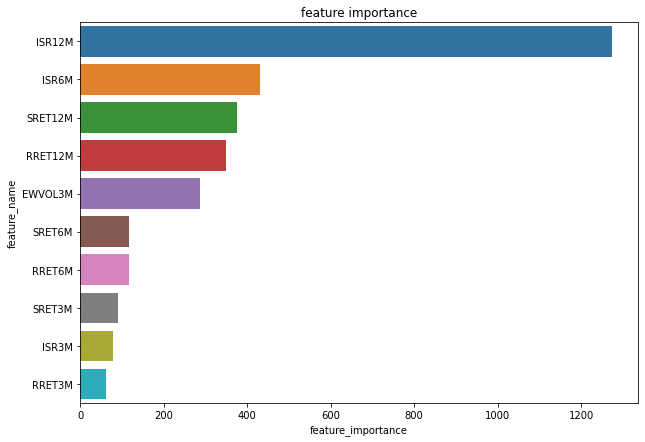

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# feature imporance
plt.figure(figsize=(10, 7))
df_plt = pd.DataFrame({'feature_name': X_train.columns.tolist(), 'feature_importance': best_ranker.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt)
plt.title('feature importance')

In [43]:
predictions = pd.DataFrame(test[["Date","symbols"]])

In [44]:

predictions["gain"] = best_ranker.predict(X_test)

In [45]:
predictions.groupby("Date")["gain"].nunique()

Date
2019-01-31    465
2019-02-28    466
2019-03-29    464
2019-04-30    468
2019-05-31    452
2019-06-28    466
2019-07-31    462
2019-08-30    453
2019-09-30    462
2019-10-31    469
2019-11-29    469
2019-12-31    469
2020-01-31    467
2020-02-28    450
2020-03-31    367
2020-04-30    377
2020-05-29    429
2020-06-30    454
2020-07-31    467
2020-08-31    459
2020-09-30    462
2020-10-30    458
2020-11-30    468
2020-12-31    467
2021-01-29    468
2021-02-26    468
2021-03-31    469
2021-04-30    468
2021-05-31    469
2021-06-30    469
2021-07-30    469
2021-08-31    469
2021-09-30    468
2021-10-29    465
2021-11-30    467
2021-12-31    467
2022-01-31    466
2022-02-28    467
2022-03-31    464
2022-04-29    455
2022-05-31    456
2022-06-30    434
2022-07-29    461
Name: gain, dtype: int64

In [46]:
predictions

,Date,symbols,gain
63315,2019-01-31,A,-1.775865
63316,2019-01-31,AA,-5.113073
63317,2019-01-31,AAPL,-2.507990
63318,2019-01-31,ABC,-3.902415
63319,2019-01-31,ABT,-0.431227
...,...,...,...
83477,2022-07-29,XRX,-4.421216
83478,2022-07-29,Y,-0.546882
83479,2022-07-29,YUM,-3.383445
83480,2022-07-29,ZBH,-4.677019


In [67]:
score_predictions = pd.pivot(
    predictions,
    index="Date",
    columns="symbols",
    values="gain"
).rank(axis=1).apply(
    pd.cut, bins=20, labels=False, axis=1
)

In [68]:
score_predictions

symbols,A,AA,AAPL,ABC,ABT,ACIW,ADBE,ADI,ADM,ADP,...,WWW,WY,XEL,XOM,XRAY,XRX,Y,YUM,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-31,14,0,12,6,17,17,16,15,15,17,...,12,1,18,6,1,9,13,17,6,7
2019-02-28,15,0,8,4,18,16,15,15,9,18,...,14,0,19,11,2,11,11,17,11,7
2019-03-29,16,0,12,7,18,17,14,15,9,19,...,14,0,19,13,9,14,9,17,14,4
2019-04-30,14,0,11,2,18,18,14,17,8,18,...,14,1,18,12,10,13,14,19,9,4
2019-05-31,12,0,9,9,17,16,13,11,6,17,...,5,1,19,7,17,15,16,19,11,3
2019-06-28,14,0,11,9,18,16,14,15,5,17,...,1,3,19,8,16,18,16,19,12,6
2019-07-31,10,0,12,12,18,15,15,15,4,17,...,1,2,19,7,14,15,13,19,13,5
2019-08-30,13,0,10,10,17,12,13,14,4,16,...,0,5,19,6,17,13,16,19,15,3
2019-09-30,11,0,10,7,15,12,10,15,4,12,...,2,7,19,3,18,12,18,18,11,6


In [69]:
mask_best = (score_predictions==19).shift(1)


In [64]:
import pickle

try: # exception handling for Google Colab pandas version

  with open(PATH + "data/config/20220831_returns_scores.pkl","rb") as f:
    return_data = pickle.load(f)
    monthly_rets = return_data["raw_returns"]["monthly"]  

except:

  daily_rets = pd.read_csv(
      PATH + "data/config/20220831_baseline_portfolio_daily_returns.csv",
      index_col="Date",
      parse_dates=["Date"]
    )
  monthly_rets = daily_rets.resample("BM").apply(lambda x: np.prod(1+x)-1)


In [65]:
monthly_rets

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,NWN,PRGO,RGP,SBCF,SHBI,UGI,WAFD,FORR,FRT,WABC
Date,,,,,,,,,,,,,,,,,,,,,
2006-10-31,0.101485,0.083089,0.043786,-0.008851,0.033784,0.085266,0.011826,0.051021,0.096360,0.024427,...,0.063013,0.059834,0.065146,-0.083851,0.068867,0.083402,0.046690,0.160207,0.090922,-0.001202
2006-11-30,-0.050771,0.130488,-0.024598,-0.017891,0.049935,0.026872,-0.085770,-0.024474,0.120544,0.011276,...,-0.003142,-0.059611,0.003110,-0.096045,-0.025785,0.063396,-0.000430,-0.105313,0.062758,0.000512
2006-12-29,0.094535,-0.074406,-0.022396,0.043935,0.023904,0.010762,-0.089459,0.026060,-0.017484,-0.006397,...,0.029098,0.030989,0.096796,0.040222,0.043959,-0.025794,0.021730,-0.035917,0.004777,0.022209
2007-01-31,-0.081779,0.010491,0.165036,0.094464,-0.054718,-0.003650,0.001251,-0.031066,0.080573,-0.011539,...,-0.032817,-0.001156,-0.013819,-0.068145,-0.049735,0.004765,-0.014450,0.038731,0.099059,-0.017184
2007-02-28,-0.007812,-0.013064,0.005116,0.030565,0.009776,0.108703,0.076981,0.042539,-0.058783,-0.017134,...,0.087982,-0.031059,0.030573,0.026828,-0.081880,-0.047428,0.025442,-0.047230,-0.031364,-0.006475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,-0.097278,-0.097131,-0.022106,-0.037239,-0.130964,-0.065383,-0.007755,-0.041136,-0.116958,-0.009172,...,-0.066038,-0.107468,0.002917,-0.071959,-0.017090,-0.053009,-0.072821,-0.012939,-0.041042,-0.026116
2022-05-31,0.069506,-0.054496,0.026248,0.034890,0.051850,0.095893,0.018743,0.021817,0.097580,0.024650,...,0.135062,0.162099,0.083529,0.053539,0.011206,0.246064,0.074561,-0.060334,-0.017854,0.029261
2022-06-30,-0.068909,-0.081430,-0.085987,-0.075004,-0.121062,-0.132482,-0.145563,-0.053388,-0.172274,-0.044690,...,-0.021919,0.024468,0.102870,-0.029804,-0.085516,-0.088537,-0.074884,-0.085802,-0.157746,-0.075569


In [72]:
mask_best

symbols,A,AA,AAPL,ABC,ABT,ACIW,ADBE,ADI,ADM,ADP,...,WWW,WY,XEL,XOM,XRAY,XRX,Y,YUM,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-28,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-03-29,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2019-04-30,False,False,False,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
2019-05-31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2019-06-28,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2019-07-31,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2019-08-30,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2019-09-30,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False


In [73]:
mask_worst = (score_predictions==0).shift(1)

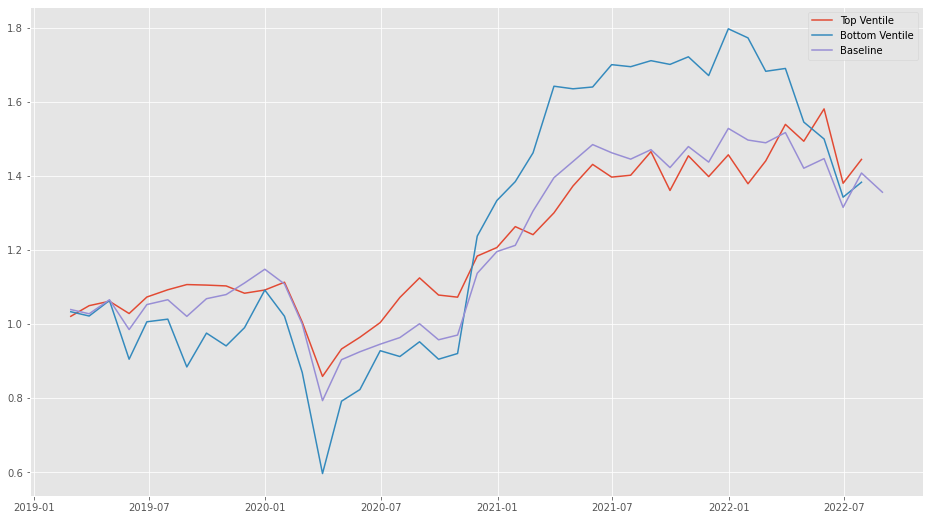

In [74]:
# Untuned
import matplotlib.pyplot as plt

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(16,9))

ax.plot((1+monthly_rets[mask_best].mean(axis=1)).cumprod(),label="Top Ventile")
ax.plot((1+monthly_rets[mask_worst].mean(axis=1)).cumprod(),label="Bottom Ventile")
ax.plot((1+monthly_rets["2019-2-28":].mean(axis=1)).cumprod(), label ="Baseline")

plt.legend()

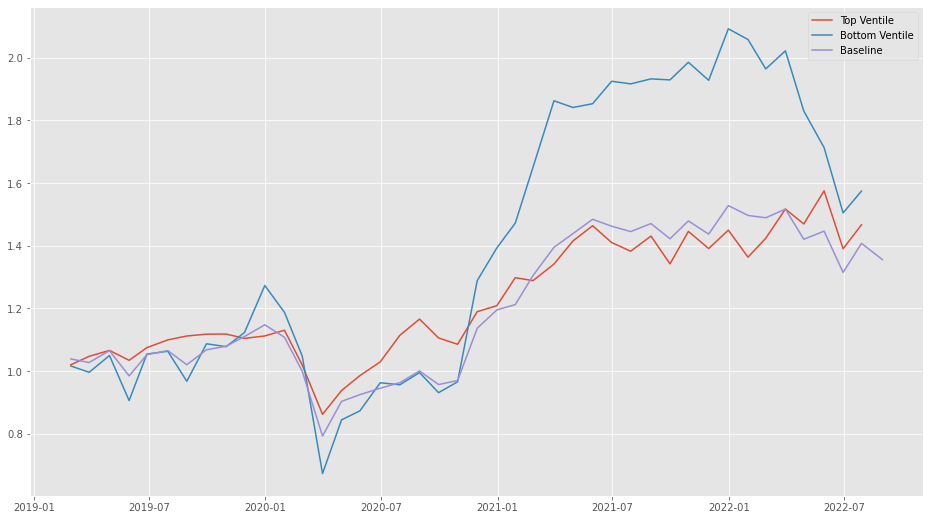

In [ ]:
# Untuned
import matplotlib.pyplot as plt

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(16,9))

ax.plot((1+port_rets_monthly[mask_best].mean(axis=1)).cumprod(),label="Top Ventile")
ax.plot((1+port_rets_monthly[mask_worst].mean(axis=1)).cumprod(),label="Bottom Ventile")
ax.plot((1+port_rets_monthly["2019-2-28":].mean(axis=1)).cumprod(), label ="Baseline")

plt.legend()

In [75]:
mask_best.shape[0]

43

In [77]:
monthly_rets.to_csv(
    PATH + "data/config/20220831_baseline_portfolio_monthly_returns.csv",
    index=False
)

#### 4.1 Random Construction

In [78]:
# Random Guess OOS
NSTOCKS  = 469
data = np.array([np.random.permutation(range(1,NSTOCKS+1)) for i in range(mask_best.shape[0])])
data

array([[435, 452, 363, ...,  93, 162, 212],
       [  4, 388, 358, ..., 361, 132, 320],
       [418,  22, 221, ..., 101, 379, 445],
       ...,
       [193, 219,  63, ..., 380, 344,   4],
       [212, 184, 374, ...,  78, 387,  72],
       [240,  44, 366, ..., 257, 114, 216]])

In [79]:
random_guess = pd.DataFrame(
    data,
    columns=mask_best.columns
)

In [80]:
random_guess.index=mask_best.index
random_relevances = random_guess.apply(pd.cut, bins=20, labels=False,axis=1)

In [81]:
random_relevances

symbols,A,AA,AAPL,ABC,ABT,ACIW,ADBE,ADI,ADM,ADP,...,WWW,WY,XEL,XOM,XRAY,XRX,Y,YUM,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-31,18,19,15,9,10,15,2,0,14,16,...,6,12,11,4,12,19,16,3,6,9
2019-02-28,0,16,15,5,13,2,9,0,13,9,...,7,15,1,10,16,1,16,15,5,13
2019-03-29,17,0,9,8,12,5,8,12,13,8,...,13,19,19,18,18,13,1,4,16,18
2019-04-30,19,12,12,4,15,16,9,2,3,4,...,18,12,2,10,1,1,7,8,9,5
2019-05-31,6,1,8,9,1,12,7,5,19,19,...,8,8,5,16,18,12,12,16,6,1
2019-06-28,1,18,7,10,10,10,16,4,4,2,...,8,0,2,13,16,10,10,4,7,17
2019-07-31,15,0,17,19,15,9,4,19,3,9,...,10,15,16,14,8,16,2,10,12,0
2019-08-30,11,17,10,18,6,1,15,12,13,12,...,8,17,1,3,6,19,10,14,17,9
2019-09-30,8,1,10,15,9,4,4,1,17,4,...,5,14,19,8,7,4,17,7,18,3


In [82]:
rnd_mask_best = (random_relevances==19).shift(1)
rnd_mask_worst = (random_relevances==0).shift(1)

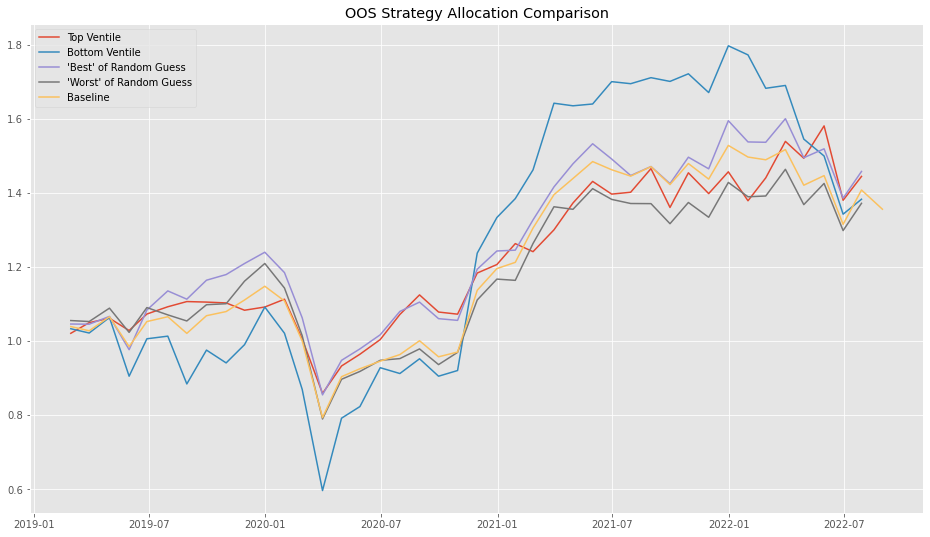

In [83]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(16,9))

# LGBMRanker Predictions (non-tuned). Train-Test Split (75%,25%)
ax.plot((1+monthly_rets[mask_best].mean(axis=1)).cumprod(),label="Top Ventile")
ax.plot((1+monthly_rets[mask_worst].mean(axis=1)).cumprod(),label="Bottom Ventile")

# Random Relevances
ax.plot((1+monthly_rets[rnd_mask_best].mean(axis=1)).cumprod(),label="'Best' of Random Guess")
ax.plot((1+monthly_rets[rnd_mask_worst].mean(axis=1)).cumprod(),label="'Worst' of Random Guess")

# Equally-Weighted Target Portfolio
ax.plot((1+monthly_rets["2019-2-28":].mean(axis=1)).cumprod(), label ="Baseline")

plt.title("OOS Strategy Allocation Comparison")
plt.legend();

In [84]:
%whos DataFrame

Variable               Type         Data/Info
---------------------------------------------
X_test                 DataFrame             RRET3M    RRET6M<...>[20167 rows x 10 columns]
X_train                DataFrame             RRET3M    RRET6M<...>[63315 rows x 10 columns]
daily_rets             DataFrame                       A     <...>[4007 rows x 469 columns]
df                     DataFrame                Date symbols <...>[83482 rows x 13 columns]
df_plt                 DataFrame      feature_name  feature_i<...>RET3M                  61
mask_best              DataFrame    symbols         A     AA <...>\n[43 rows x 469 columns]
mask_worst             DataFrame    symbols         A     AA <...>\n[43 rows x 469 columns]
monthly_rets           DataFrame                       A     <...>n[191 rows x 469 columns]
port_rets_monthly      DataFrame                       A     <...>n[191 rows x 469 columns]
predictions            DataFrame                Date symbols <...>n[20167 rows x

#### 4.2 Oracle Construction (Perfecte Knowledge of the Future ISharpe Ratio)

In [85]:
oracle_allocation = pd.pivot(
    test[["Date","symbols","relevance"]],
    index="Date",
    columns="symbols",
    values="relevance"
)

In [86]:
top_crystal_ball = (oracle_allocation==19).shift(1)

In [87]:
top_crystal_ball

symbols,A,AA,AAPL,ABC,ABT,ACIW,ADBE,ADI,ADM,ADP,...,WWW,WY,XEL,XOM,XRAY,XRX,Y,YUM,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-28,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2019-03-29,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2019-04-30,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2019-05-31,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2019-06-28,False,False,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2019-07-31,False,False,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2019-08-30,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2019-09-30,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


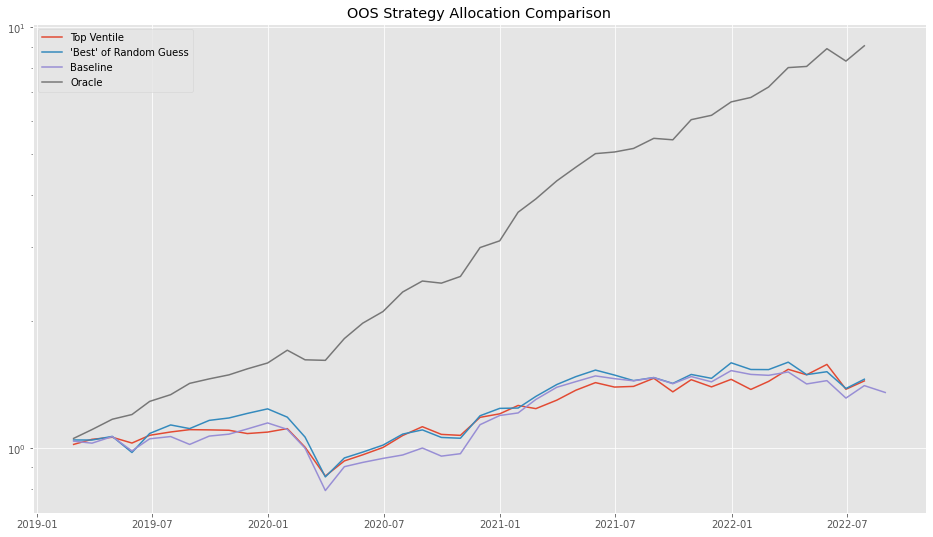

In [109]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(16,9))

# LGBMRanker Predictions (non-tuned). Train-Test Split (75%,25%)
ax.plot((1+monthly_rets[mask_best].mean(axis=1)).cumprod(),label="Top Ventile")

# Random Relevances
ax.plot((1+monthly_rets[rnd_mask_best].mean(axis=1)).cumprod(),label="'Best' of Random Guess")

# Equally-Weighted Target Portfolio
ax.plot((1+monthly_rets["2019-2-28":].mean(axis=1)).cumprod(), label ="Baseline")

# Oracle Allocations (100% succesfully ranking)
ax.plot((1+monthly_rets[top_crystal_ball].mean(axis=1)).cumprod(), label ="Oracle")

plt.title("OOS Strategy Allocation Comparison")
plt.legend()
plt.semilogy();

**Some Concluding Remarks**:

1. Non-Tuned `LGMBRanker` pairwise ranker does not provide a userful ranking: there's a big difference with the `Oracle` strategy.
2. `Random` Strategies are not significantly different from the ranked ones.
3. Moreover, it seems that if we choose worst predicted performers we tend to outperform top predicted performers. This is a nonsensical outcome and it could be signaling of bad ranking predictions.
4. In sum, it is not clear that this base portfolio could be outperformed by letor-based stock picking for the futures, stocks and train-test set considered.

In [89]:
def stock_alloc(mask):    
    
    stock_picking_timeseries={}

    for i, d in enumerate(mask_best.index):
        try:
            stock_chosen = mask_best.columns[mask.iloc[i]].tolist()
        except:
            stock_chosen = []        
        d = d.strftime("%Y-%m-%d")
        stock_picking_timeseries[d] = stock_chosen 
        
    return pd.DataFrame.from_dict(stock_picking_timeseries, orient="index")

In [90]:
oracle_stocks_picked = stock_alloc(top_crystal_ball)

In [91]:
lgbmranker_stocks_picked = stock_alloc(mask_best)

In [92]:
def accuracy_alloc(oracle, model):
    
    size_port = len(oracle.columns)
    tp_lst = []
    
    for i, _ in enumerate(oracle.index):
        tp_lst.append(
            len(
                set(model.iloc[i]
            ).intersection(oracle.iloc[i])))
    
    hits = pd.DataFrame(tp_lst, index=oracle.index, columns=["hits"])
    hits["prcnt"] = 100*hits["hits"]/size_port
    
    return hits

In [93]:
random_stocks_picked = stock_alloc(rnd_mask_best)
random_stocks_picked

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2019-01-31,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2019-02-28,AA,AEE,ARE,AVT,BRC,CPSI,CTO,DOV,EA,GOOGL,...,PCG,PKE,PPL,SEE,SWX,TRC,TXN,VSAT,WW,XRX
2019-03-29,AES,AMD,BMY,BPOP,DOV,EPAC,EXC,EXPD,IBM,KEY,...,NKTR,NSC,ODP,PVH,SCHL,T,URBN,USB,WMB,WRE
2019-04-30,BK,CBSH,CYH,EA,ECL,GWW,HAIN,HSII,ITRI,JEF,...,PCAR,SAFT,SBCF,SCS,SHBI,SLG,VFC,WRE,WY,XEL
2019-05-31,A,AES,AVA,BOH,CSCO,CTBI,DISH,FLR,FULT,GE,...,MCK,MTX,NATI,NWN,OFC,PCG,PRU,RNST,SHBI,WAFD
2019-06-28,ADM,ADP,BANR,BPOP,CAH,CTAS,FBP,FE,FORM,GLT,...,MGI,NHC,OI,PEP,PLCE,PPG,RCII,SCSC,URBN,WHR
2019-07-31,AEO,AMD,BAX,BFS,BHLB,BZH,CB,CFFN,DVA,EIX,...,LEG,NATI,PAYX,PKE,PNC,SCSC,SHW,SP,VLY,WMT
2019-08-30,ABC,ADI,BF-B,BSRR,BXP,CDE,CTAS,CVS,DGX,EL,...,KELYA,LEG,MATW,MCS,MKL,NYCB,PNM,SCSC,TROW,WMT
2019-09-30,AIG,AKR,BAC,BHLB,BKD,BSRR,CAT,DISH,FCF,GD,...,KIM,KLAC,MSFT,POR,PPL,RF,SEE,SRDX,WAFD,XRX
2019-10-31,AVT,BCO,BFS,BK,D,DHI,EPAC,FBP,FCBC,HNI,...,NOC,NWLI,PCG,PPL,SKT,SYK,UBA,USB,VSH,XEL


In [98]:
hits_random = accuracy_alloc(oracle_stocks_picked, random_stocks_picked)
hits_lgbmranker = accuracy_alloc(oracle_stocks_picked, lgbmranker_stocks_picked)

In [100]:
hits_lgbmranker = hits_lgbmranker.iloc[1:]
hits_random = hits_random.iloc[1:]

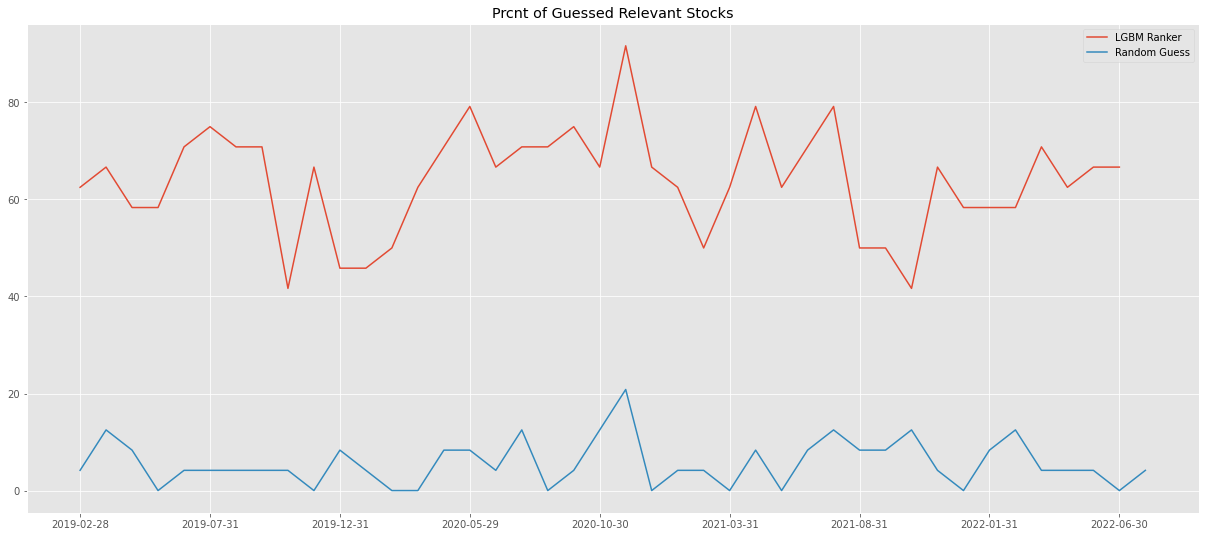

In [101]:
hits_lgbmranker["prcnt"].rename("LGBM Ranker").plot(figsize=(21,9), legend=True, title="Prcnt of Guessed Relevant Stocks")
hits_random["prcnt"].rename("Random Guess").plot(legend=True)

In [108]:
print(f"Avg of top stocks ranked {hits_lgbmranker['prcnt'].describe()['50%']:.2f}%")
print(f"Avg of top stocks ranked {hits_random['prcnt'].describe()['50%']:.2f}%")


Avg of top stocks ranked 66.67%
Avg of top stocks ranked 4.17%
